In [1]:
import pickle
import imageio
import random
import PIL
import torch
import natsort
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from torch.utils import data
import numpy as np
import os, sys, time
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
def cifar_batches_to_images(data_path, save_path, save=True):
    for file in os.listdir(data_path):
        if file.startswith('data') or file.startswith('test'):
            path_ = os.path.join(save_path + file)
            if not os.path.exists(path_): os.makedirs(path_)
                
            with open(os.path.join(data_path, file), 'rb') as fo:
                files = pickle.load(fo, encoding = 'latin1')
                images = files['data']
                label = files['labels']
                images = images.reshape(images.shape[0], 3, 32, 32).transpose(0, 2, 3, 1)
                if save:
                    for i in range(images.shape[0]):
                        name = path_ + '/i{}_{}'.format(i, label[i]) + '.jpg'
                        imageio.imwrite(name, images[i])

In [3]:
cifar_batches_to_images(data_path='../data/cifar-10-batches-py/', save_path='../data/cifar10/', save=False)

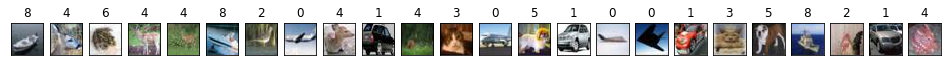

In [4]:
plt.rcParams["figure.figsize"] = (1200/72., 4.8)
def show_images(path='../data/cifar10/', num=24):
    folder = random.choice([f for f in os.listdir(path)])
    file_name = [f for f in os.listdir(os.path.join(path, folder))]
    for i in range(num):
        name = random.choice(file_name)
        label = name[:-4][-1]
        img = PIL.Image.open(os.path.join(path, folder, name))
        plt.subplot(1,num,i+1)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
    plt.show()
    return
show_images()

In [5]:
class ImageLoader(data.Dataset):
    def __init__(self, folder):
        self.folder = folder 
        self.files = natsort.natsorted(os.listdir(folder))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = PIL.Image.open(os.path.join(self.folder, self.files[idx]))
        return np.array(image), self.files[idx][:-4][-1]

In [6]:
def create_KFold_data(num_folds=5, fold='5', path='../data/cifar10/', display_info=False):
    temp_dataset = []
    for folder in os.listdir(path):
        
        full_path = os.path.join(path+folder)
        if folder == 'test_batch': test_dataset = ImageLoader(full_path)
        if folder.endswith(fold): val_dataset = ImageLoader(full_path)
        else:
            temp_dataset.append(ImageLoader(full_path))
        train_dataset = data.ConcatDataset(temp_dataset)
        
    if display_info:
        
        fig = plt.figure(figsize = (2,2))
        ax1 = fig.add_subplot(1,3,1, xticks=[], yticks=[])
        ax2 = fig.add_subplot(1,3,2, xticks=[], yticks=[])
        ax3 = fig.add_subplot(1,3,3, xticks=[], yticks=[])
        ax1.set_title(next(iter(train_dataset))[1])
        ax2.set_title(next(iter(val_dataset))[1])
        ax3.set_title(next(iter(test_dataset))[1])
        print('Train ::: count = {}'.format(len(train_dataset)))
        print('Val ::: count = {}'.format(len(val_dataset)))
        print('Test ::: count = {}'.format(len(test_dataset)))
        print('Examples: ')
        ax1.imshow(next(iter(train_dataset))[0])
        ax2.imshow(next(iter(val_dataset))[0])
        ax3.imshow(next(iter(test_dataset))[0])
        
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = create_KFold_data(display_info=False)

In [11]:
class Args():
    def __init__(self):
        self.batch_size = 256
args = Args()

In [12]:
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=args.batch_size)
val_loader = data.DataLoader(val_dataset, shuffle=True, batch_size=args.batch_size)
test_loader = data.DataLoader(test_dataset, shuffle=True, batch_size=args.batch_size)

In [13]:
class Net(nn.Module):
    def __init__(self, activation):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.activation = activation 
        self.fc = nn.Linear(21632, 10)
    def forward(self, x):
        x = x.reshape(x.shape[0], 3, 32, 32).float()
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = x.reshape(x.shape[0], -1)
        return F.log_softmax(self.fc(x))

In [16]:
model = Net(activation=nn.ReLU()).cuda()

In [17]:
def train(cuda, trainloader, model, optimizer):
        correct = 0
        loss_ = []
        model.train().cpu()
        for data, target in tqdm(trainloader):
            target = torch.tensor(np.array([target], dtype=np.int)).squeeze()
            if cuda:
                data, target = data.to('cuda:0'), target.to('cuda:0')
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss_.append(loss.item())
            softmax_output = torch.exp(output)
            top_p, top_class = softmax_output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            correct += torch.mean(equals.type(torch.FloatTensor)).item()
            loss.backward()
            optimizer.step()
        return loss_, sum(loss_)/len(trainloader), int((correct/len(trainloader))*100)
    
def test(cuda, loader, model):
        correct = 0
        loss_ = []
        model.eval()
        for data, target in tqdm(loader):
            target = torch.tensor(np.array([target], dtype=np.int)).squeeze()
            if cuda:
                data, target = data.to('cuda:0'), target.to('cuda:0')
            output = model(data)
            loss = F.nll_loss(output, target)
            loss_.append(loss.item())
            softmax_output = torch.exp(output)
            top_p, top_class = softmax_output.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            correct += torch.mean(equals.type(torch.FloatTensor)).item()
        return loss_, sum(loss_)/len(loader), int((correct/len(loader))*100)

In [18]:
for i in range(1):
    tr_loss, tr_acc, te_loss, te_acc, val_loss, val_acc = [], [], [], [], [], []
    optimizer = torch.optim.Adam(model.parameters(), 0.0001)
    l, _, a = train(cuda=True, trainloader=train_loader, model=model, optimizer=optimizer)
    tr_loss.append(l)
    tr_acc.append(a)
    l, _, a = test(cuda=True, trainloader=val_loader, model=model)
    val_loss.append(l)
    val_acc.append(a)
    l, _, a = test(cuda=True, trainloader=test_loader, model=model)
    te_loss.append(l)
    te_acc.append(a)
    clear_output()
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.plot(te_loss)
    plt.show()
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.plot(tr_acc)
    plt.show()

RuntimeError: CUDA error: no kernel image is available for execution on the device